In [35]:
# imports 
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.text import TSNEVisualizer
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

plt.style.use('ggplot')
rcParams['figure.figsize'] = (12,6)

#### Prepare

In [36]:
data_dir = ''

In [37]:
# load data
lyrics = pd.read_csv(data_dir + 'clean_lyrics_df.csv')
artist = pd.read_csv(data_dir + 'artists-data.csv')

lyrics['ALink'] = lyrics['ALink'].apply(lambda x: f'/{x.replace(" ","-")}/')

df = lyrics.merge(artist, left_on='ALink', right_on='Link')
df.drop(df[df['language']!='en'].index, inplace=True)
df.drop(['ALink','SLink','Link','language'], axis=1, inplace=True)
df.rename(columns={'SName': 'Title'}, inplace=True)

#### Explore

Holistic Exploration

In [38]:
df.head()

,Title,Lyric,Artist,Genres,Songs,Popularity
0,In da Club,"go, go, go, go\ngo, go, go shawty\nit's your b...",50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
1,21 Questions,new york city!\nyou are now rapping...with 50 ...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
2,P.I.M.P.,i don't know what you heard about me\nbut a b*...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
3,Many Men (Wish Death),man we gotta go get something to eat man\ni'm ...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
4,Candy Shop,yeah...\nuh huh\nso seductive\ni'll take you t...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7


In [39]:
df.tail()

,Title,Lyric,Artist,Genres,Songs,Popularity
13942,You Oughta Be Home With Me,"everybody's here, spinnin' the bottle\neverybo...",Barry Manilow,Romântico,330.0,0.0
13943,You're Leaving Too Soon,you're leavin' too soon\nyou oughta try believ...,Barry Manilow,Romântico,330.0,0.0
13944,You're Looking Hot Tonight,you're looking hot tonight\nbarry manilow\nby:...,Barry Manilow,Romântico,330.0,0.0
13945,You're There,our friends all use the past tense when they s...,Barry Manilow,Romântico,330.0,0.0
13946,Young At Heart,"fairy tales can come true, it can happen to yo...",Barry Manilow,Romântico,330.0,0.0


In [40]:
df.shape

(13947, 6)

In [41]:
df.describe(include='all')

,Title,Lyric,Artist,Genres,Songs,Popularity
count,13947,13947,13947,13947,13947.000000,13947.000000
unique,12897,13947,32,28,NaN,NaN
top,White Christmas,"soon, my dear, you'll never be lonely,\nsoon, ...",Frank Sinatra,Country,NaN,NaN
freq,9,1,798,1436,NaN,NaN
mean,NaN,NaN,NaN,NaN,515.140030,12.947637
std,NaN,NaN,NaN,NaN,151.378789,22.763154
min,NaN,NaN,NaN,NaN,323.000000,0.000000
25%,NaN,NaN,NaN,NaN,378.000000,1.300000
50%,NaN,NaN,NaN,NaN,505.000000,3.300000
75%,NaN,NaN,NaN,NaN,621.000000,14.100000


- Titles recur, but this is expected given covers, rewrites, and generic titles

In [42]:
df.drop_duplicates(subset='Lyric', keep=False, inplace=True)
df.shape

(13947, 6)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13947 entries, 0 to 13946
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       13947 non-null  object 
 1   Lyric       13947 non-null  object 
 2   Artist      13947 non-null  object 
 3   Genres      13947 non-null  object 
 4   Songs       13947 non-null  float64
 5   Popularity  13947 non-null  float64
dtypes: float64(2), object(4)
memory usage: 762.7+ KB


Individual Variable Exploration

In [44]:
df['Genres'].value_counts(normalize=True)

Country                         0.102961
Hip Hop; Rap; Black Music       0.081308
Jazz; Clássico; Romântico       0.057217
Rockabilly; Romântico; Rock     0.053345
Indie                           0.043594
R&B; Black Music; Funk          0.039865
R&B; Black Music; Rap           0.039077
Folk; Rock; Country             0.038790
Folk; Country; Rock             0.038575
Country; Folk                   0.038073
Rock; Folk                      0.036639
Rock                            0.035850
Rap; Hip Hop; Pop               0.034488
Rockabilly                      0.031190
Hip Hop; Rap                    0.028178
Jazz                            0.028106
Blues                           0.026457
Hard Rock; Rock; Pop/Rock       0.026171
Pop; Romântico; Pop/Rock        0.025812
R&B; Soul Music; Disco          0.024952
Dance; Pop                      0.024593
Surf Music; Rock                0.023661
Romântico                       0.023518
Rock; Hard Rock; Heavy Metal    0.023303
Indie; Rock     

- Subgenres occur within several genre 'sets'

In [45]:
df['Songs'].describe()

count    13947.000000
mean       515.140030
std        151.378789
min        323.000000
25%        378.000000
50%        505.000000
75%        621.000000
max        828.000000
Name: Songs, dtype: float64

In [46]:
df['Popularity'].describe()

count    13947.000000
mean        12.947637
std         22.763154
min          0.000000
25%          1.300000
50%          3.300000
75%         14.100000
max        114.900000
Name: Popularity, dtype: float64

- Popularity varies widely, and the meaning of the values is unclear
- Values range from 0 to 114. Normalizing might be prudent

In [47]:
# Normalize popularity
df['PopNorm'] = (df['Popularity'] - df['Popularity'].min()) / (df['Popularity'].max() - df['Popularity'].min())
df['PopNorm'].describe()

count    13947.000000
mean         0.112686
std          0.198113
min          0.000000
25%          0.011314
50%          0.028721
75%          0.122715
max          1.000000
Name: PopNorm, dtype: float64

Bivariate Exploration

In [48]:
df['Genre_1'] = df['Genres'].apply(lambda x: x.split(';')[0])
top_10_genres = df.groupby('Genre_1')['Title'].count().sort_values(ascending=False).reset_index()['Genre_1'][:10]

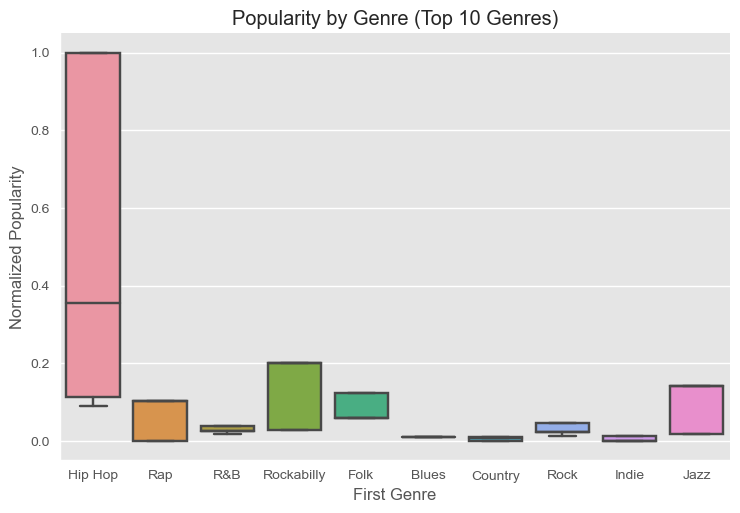

Not very informative...


In [49]:
sns.catplot(x='Genre_1', y='PopNorm', data=df[df['Genre_1'].isin(top_10_genres)], kind='box', aspect=1.5)
plt.title("Popularity by Genre (Top 10 Genres)")
plt.xlabel('First Genre')
plt.ylabel('Normalized Popularity')
plt.show()
print('Not very informative...')

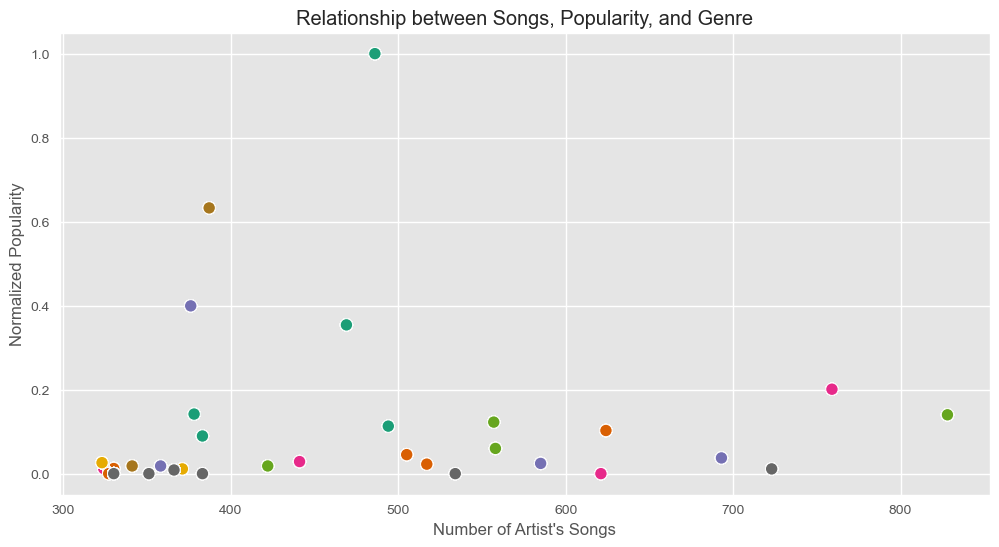

In [50]:
sns.scatterplot(x="Songs", y="PopNorm", hue="Genre_1", data=df, palette="Dark2", s=80, legend=False)
plt.title("Relationship between Songs, Popularity, and Genre")
plt.xlabel('Number of Artist\'s Songs')
plt.ylabel('Normalized Popularity')
plt.show()